<a href="https://colab.research.google.com/github/ochouchene/-Data-Gathering-with-API-/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier


In [4]:
data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [6]:
data['Age'] = data['Age'].fillna(data['Age'].median())

data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

data.drop(columns=['Cabin'], inplace=True)

In [7]:
data.drop(columns=['PassengerId', 'Ticket'], inplace=True)

In [9]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [10]:
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify rare titles
data['Title'] = data['Title'].replace(
    ['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],
    'Rare'
)
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

data.drop(columns=['Name'], inplace=True)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-4283724335.py:1: SyntaxWarning: invalid escape sequence '\.'
  data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


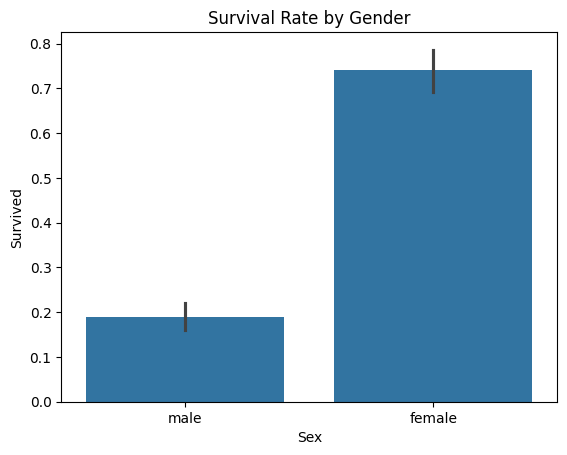

In [11]:
sns.barplot(x='Sex', y='Survived', data=data)
plt.title("Survival Rate by Gender")
plt.show()

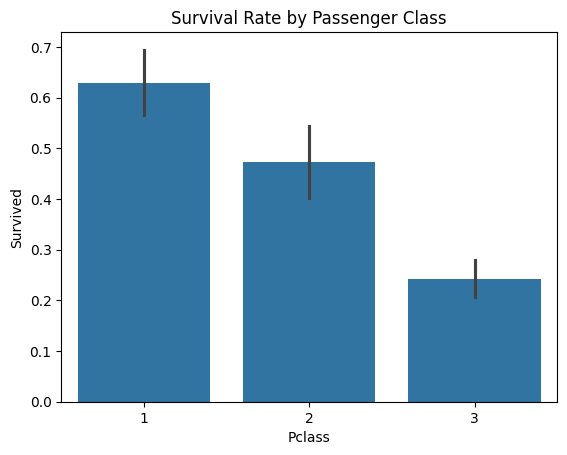

In [12]:
sns.barplot(x='Pclass', y='Survived', data=data)
plt.title("Survival Rate by Passenger Class")
plt.show()

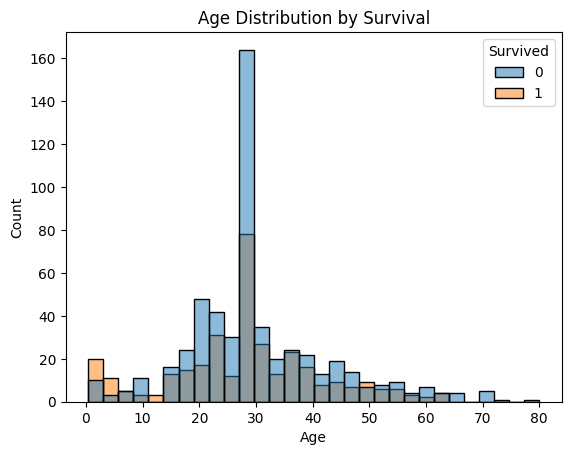

In [13]:
sns.histplot(data=data, x='Age', hue='Survived', bins=30)
plt.title("Age Distribution by Survival")
plt.show()

In [14]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [15]:
categorical_features = ['Sex', 'Embarked', 'Title']
numerical_features = X.drop(columns=categorical_features).columns

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

In [17]:
model = RandomForestClassifier(random_state=42)

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'Title']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [21]:
y_pred = grid_search.predict(X_test)

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8268156424581006

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



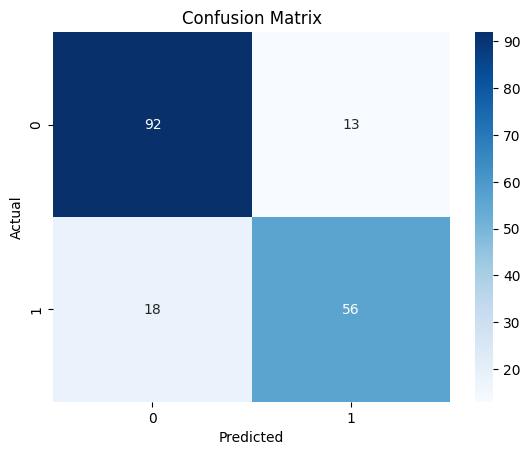

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [24]:
cv_scores = cross_val_score(
    grid_search.best_estimator_,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

print("Cross-validation accuracy:", cv_scores.mean())

Cross-validation accuracy: 0.8305128366078716
